In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *

In [3]:
path = 'cifar/train'
#path.ls()
#path_anno = path/'annotations'
path_img = path
fnames = get_image_files(path_img)
np.random.seed(2)
pat = r'/\d+_([^/]+).png$'

In [4]:
fnames

[PosixPath('cifar/train/16195_deer.png'),
 PosixPath('cifar/train/35525_cat.png'),
 PosixPath('cifar/train/41443_frog.png'),
 PosixPath('cifar/train/9974_frog.png'),
 PosixPath('cifar/train/49897_ship.png'),
 PosixPath('cifar/train/14771_horse.png'),
 PosixPath('cifar/train/3885_ship.png'),
 PosixPath('cifar/train/40093_ship.png'),
 PosixPath('cifar/train/10833_bird.png'),
 PosixPath('cifar/train/16441_bird.png'),
 PosixPath('cifar/train/21061_dog.png'),
 PosixPath('cifar/train/21664_ship.png'),
 PosixPath('cifar/train/35740_bird.png'),
 PosixPath('cifar/train/35719_ship.png'),
 PosixPath('cifar/train/28771_horse.png'),
 PosixPath('cifar/train/29064_horse.png'),
 PosixPath('cifar/train/38980_airplane.png'),
 PosixPath('cifar/train/166_truck.png'),
 PosixPath('cifar/train/19808_cat.png'),
 PosixPath('cifar/train/4483_cat.png'),
 PosixPath('cifar/train/5383_truck.png'),
 PosixPath('cifar/train/20864_bird.png'),
 PosixPath('cifar/train/5853_dog.png'),
 PosixPath('cifar/train/18961_automob

In [5]:
bs=256

In [12]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=None, size=32, bs=bs
                                  ).normalize(imagenet_stats)

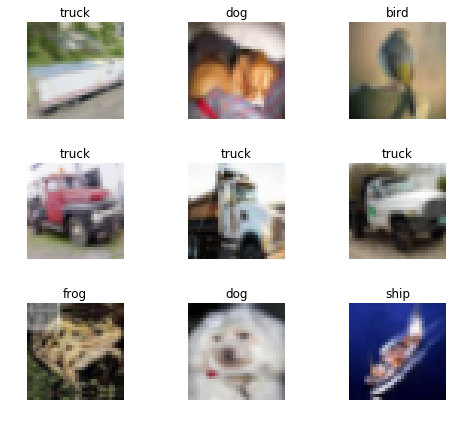

In [7]:
data.show_batch(rows=3, figsize=(7,6))


In [8]:
lr = 1e-2

In [9]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return x

In [7]:
#def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
#model = nn.Sequential(
#    conv(3, 8), # 14
#    nn.BatchNorm2d(8),
#    nn.ReLU(),
#    conv(8, 16), # 7
#    nn.BatchNorm2d(16),
#    nn.ReLU(),
#    conv(16, 32), # 4
#    nn.BatchNorm2d(32),
#    nn.ReLU(),
#    conv(32, 16), # 2
#    nn.BatchNorm2d(16),
#    nn.ReLU(),
#    conv(16, 10), # 1
#    nn.BatchNorm2d(10),
#    Flatten()     # remove (1,1) grid
#)

In [13]:
model = SimpleNet([32*32*3,40,10])
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
learn.summary()

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


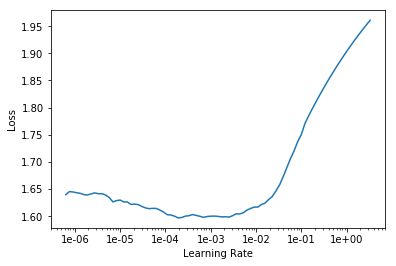

In [17]:
learn.recorder.plot()


In [18]:
learn.fit_one_cycle(2,max_lr = 5e-03)

epoch,train_loss,valid_loss,accuracy,time
0,1.604935,1.661875,0.434600,00:05
1,1.604106,1.658600,0.437100,00:06


In [ ]:
learn.fit_one_cycle(2,max_lr = 1e-04)

In [19]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.out(x)

In [20]:
model = ConvNet([3,20,40,80],10)
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [21]:
learn.summary()

ConvNet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [20, 15, 15]         560        True      
______________________________________________________________________
Conv2d               [40, 7, 7]           7,240      True      
______________________________________________________________________
Conv2d               [80, 3, 3]           28,880     True      
______________________________________________________________________
AdaptiveMaxPool2d    [80, 1, 1]           0          False     
______________________________________________________________________
Linear               [10]                 810        True      
______________________________________________________________________

Total params: 37,490
Total trainable params: 37,490
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : Cross

In [22]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


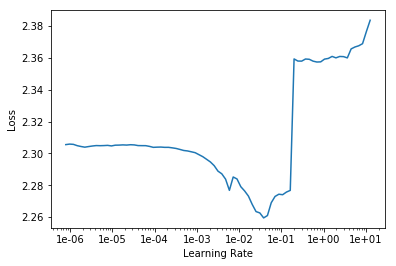

In [23]:
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(2,max_lr = 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.673199,1.515448,0.451500,00:06
1,1.342784,1.336897,0.517300,00:06


In [25]:
learn.fit_one_cycle(4,max_lr = 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.316819,1.377660,0.502800,00:06
1,1.265654,1.265875,0.549900,00:06
2,1.100487,1.192978,0.577100,00:06
3,0.940505,1.169996,0.591700,00:06


# Refactored


In [26]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [37]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return self.out(x)

In [38]:
model = ConvNet2([3,20,40,80],10)
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [39]:
learn.summary()

ConvNet2
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [20, 16, 16]         560        True      
______________________________________________________________________
Conv2d               [40, 8, 8]           7,240      True      
______________________________________________________________________
Conv2d               [80, 4, 4]           28,880     True      
______________________________________________________________________
Linear               [10]                 810        True      
______________________________________________________________________

Total params: 37,490
Total trainable params: 37,490
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : CrossEntropyLoss
Callbacks functions applied 

In [40]:
learn.fit_one_cycle(2,max_lr = 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.680270,1.611092,0.411000,00:06
1,1.359045,1.331992,0.519200,00:06


In [41]:
learn.fit_one_cycle(4,max_lr = 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.323746,1.388137,0.499300,00:06
1,1.280466,1.258439,0.544600,00:06
2,1.110251,1.151870,0.594200,00:06
3,0.956759,1.124627,0.604200,00:06


In [54]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        self.means = torch.zeros(nf,1,1).cuda()
        self.stds = torch.ones(nf,1,1).cuda()
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [55]:

class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return self.out(x)

In [56]:
model = ConvBnNet([10,20,40,80,160],10)
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [57]:
learn.summary()

ConvBnNet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [10, 32, 32]         760        True      
______________________________________________________________________
Conv2d               [20, 16, 16]         1,800      True      
______________________________________________________________________
Conv2d               [40, 8, 8]           7,200      True      
______________________________________________________________________
Conv2d               [80, 4, 4]           28,800     True      
______________________________________________________________________
Conv2d               [160, 2, 2]          115,200    True      
______________________________________________________________________
Linear               [10]                 1,610      True      
______________________________________________________________________

Total params: 155,370
Total trainable params: 155,370
Total non-trainable params: 0
Optimized with 'torch.optim.ada

In [58]:
learn.fit_one_cycle(2,max_lr = 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.371638,1.208706,0.566900,00:06
1,1.006349,0.995533,0.650300,00:07


In [59]:
learn.fit_one_cycle(4,max_lr = 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.018696,1.121267,0.608200,00:06
1,0.905371,0.931686,0.677200,00:07
2,0.675135,0.857555,0.709700,00:07
3,0.426898,0.840483,0.720400,00:07


In [60]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return self.out(x)

In [61]:
model = ConvBnNet2([10,20,40,80,160],10)
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [62]:
learn.summary()

ConvBnNet2
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [10, 32, 32]         760        True      
______________________________________________________________________
Conv2d               [20, 16, 16]         1,800      True      
______________________________________________________________________
Conv2d               [40, 8, 8]           7,200      True      
______________________________________________________________________
Conv2d               [80, 4, 4]           28,800     True      
______________________________________________________________________
Conv2d               [160, 2, 2]          115,200    True      
______________________________________________________________________
Conv2d               [20, 16, 16]         3,600      True      
______________________________________________________________________
Conv2d               [40, 8, 8]           14,400     True      
___________________________________________________

In [63]:
learn.fit_one_cycle(2,max_lr = 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.451903,1.326104,0.521300,00:08
1,1.024306,0.985019,0.649400,00:08


In [64]:
learn.fit_one_cycle(4,max_lr = 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.056202,1.088616,0.617700,00:08
1,0.922525,0.914846,0.681600,00:08
2,0.691052,0.744762,0.739700,00:08
3,0.430263,0.744379,0.752300,00:08


# Resnet

In [65]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [95]:
class Resnet(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return self.out(x)

In [104]:
model = Resnet([16,32,64,128,256],10,0.5)
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [83]:
learn.summary()

Resnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 28, 28]         2,352      True      
______________________________________________________________________
Conv2d               [32, 14, 14]         4,608      True      
______________________________________________________________________
Conv2d               [64, 7, 7]           18,432     True      
______________________________________________________________________
Conv2d               [128, 4, 4]          73,728     True      
______________________________________________________________________
Conv2d               [256, 2, 2]          294,912    True      
______________________________________________________________________
Conv2d               [32, 14, 14]         9,216      True      
______________________________________________________________________
Conv2d               [64, 7, 7]           36,864     True      
_______________________________________________________

In [105]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


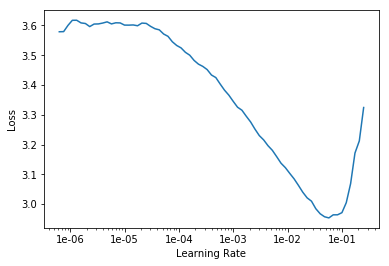

In [106]:
learn.recorder.plot()

In [107]:
learn.fit_one_cycle(10,max_lr = 5e-03)

epoch,train_loss,valid_loss,accuracy,time
0,1.856455,1.485649,0.471900,00:11
1,1.452750,1.398302,0.504900,00:11
2,1.257312,1.096908,0.610900,00:11
3,1.040450,0.981575,0.656400,00:11
4,0.865538,0.860216,0.704900,00:11
5,0.702510,0.792422,0.732600,00:12
6,0.536637,0.749134,0.758700,00:11
7,0.311969,0.791903,0.765400,00:11
8,0.126677,0.918089,0.768500,00:11
9,0.055021,0.938797,0.771800,00:12


In [94]:
learn.fit_one_cycle(4,max_lr = 5e-04)

epoch,train_loss,valid_loss,accuracy,time
0,0.598379,0.819568,0.713900,00:11
1,0.569006,0.815877,0.720100,00:11
2,0.395551,0.846431,0.728800,00:12
3,0.237569,0.870140,0.734400,00:11
